# Tarefa: previsão do valor total de vendas

Nesta tarefa você deve criar uma rede neural com somente uma saída para prever somente o valor do atributo global_sales , que representa as vendas totais dos jogos. Siga as recomendações abaixo:

- Os atributos que representam as vendas na América do Norte, Europa e Japão devem ser excluídos

- O número de neurônios na camada de entrada deverá ser modificado de acordo com a quantidade de atributos previsores

- A rede neural terá somente um neurônio na camada de saída

Utilizando a mesma estrutura da rede neural desenvolvida anteriormente, os resultados não serão tão bons quanto aos da execução anterior, portanto, você pode testar outras configurações conforme você aprendeu durante todo o curso.

## Etapa 1: Importação das bibliotecas

In [1]:
!pip install torch==1.4.0

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

## Etapa 2: Base de dados

In [3]:
torch.manual_seed(123)

In [4]:
df = pd.read_csv('games.csv')

In [5]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(16719, 16)

In [7]:
df.drop(['NA_Sales','EU_Sales','Other_Sales','JP_Sales','Developer','Name'], axis = 1, inplace=True)
df.shape

(16719, 10)

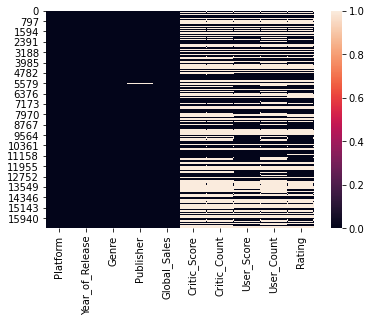

In [8]:
sns.heatmap(df.isnull());

In [9]:
df.dropna(axis=0, inplace=True)

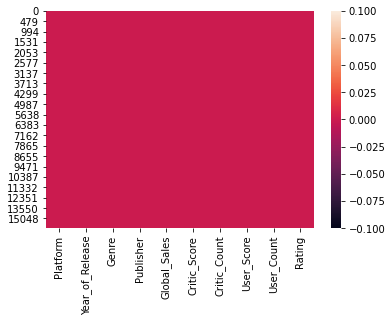

In [10]:
sns.heatmap(df.isnull());

In [11]:
df.shape

(6825, 10)

In [12]:
df.loc[df['Global_Sales'] > 1]

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,2006.0,Sports,Nintendo,82.53,76.0,51.0,8,322.0,E
2,Wii,2008.0,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,E
3,Wii,2009.0,Sports,Nintendo,32.77,80.0,73.0,8,192.0,E
6,DS,2006.0,Platform,Nintendo,29.80,89.0,65.0,8.5,431.0,E
7,Wii,2006.0,Misc,Nintendo,28.92,58.0,41.0,6.6,129.0,E
...,...,...,...,...,...,...,...,...,...,...
2050,X360,2014.0,Action,Ubisoft,1.01,72.0,32.0,7.3,318.0,M
2051,PS4,2014.0,Platform,Ubisoft,1.01,90.0,16.0,8.5,525.0,E10+
2053,X360,2008.0,Action,Ubisoft,1.01,81.0,73.0,7,189.0,T
2055,WiiU,2012.0,Action,Ubisoft,1.01,77.0,70.0,7.7,758.0,M


In [13]:
df.drop(df.loc[df['Global_Sales'] <= 1].index, axis=0, inplace=True)

In [14]:
df.shape

(1307, 10)

In [15]:
X = df.iloc[:, [0,1,2,3,5,6,7,8,9]].values
y = df.iloc[:,4].values

In [16]:
X

array([['Wii', 2006.0, 'Sports', ..., '8', 322.0, 'E'],
       ['Wii', 2008.0, 'Racing', ..., '8.3', 709.0, 'E'],
       ['Wii', 2009.0, 'Sports', ..., '8', 192.0, 'E'],
       ...,
       ['X360', 2008.0, 'Action', ..., '7', 189.0, 'T'],
       ['WiiU', 2012.0, 'Action', ..., '7.7', 758.0, 'M'],
       ['WiiU', 2016.0, 'Fighting', ..., '8', 273.0, 'E10+']],
      dtype=object)

In [17]:
y

array([82.53, 35.52, 32.77, ...,  1.01,  1.01,  1.01])

In [18]:
oneHot = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(),
                                          [0,2,3,8])], remainder='passthrough')
X = oneHot.fit_transform(X).toarray()

In [19]:
X.shape

(1307, 99)

## Etapa 3: Construção do modelo

In [20]:
# (Entradas + Saídas) / 2
# Entradas = 99
# Saídas = 1
# (99 + 1) / 2 = 50
class reg_torch(nn.Module):
  def __init__(self):
    super().__init__()
    self.dense0 = nn.Linear(99, 50)
    self.activation0 = nn.ReLU()
    self.dense1 = nn.Linear(50, 50)
    self.activation1 = nn.ReLU()
    self.output = nn.Linear(50, 1)
    self.activation2 = nn.Sigmoid()
    self.dropout = nn.Dropout(0.2)


  def forward(self, X):
    X = self.dense0(X)
    X = self.activation0(X)
    X = self.dropout(X)
    X = self.dense1(X)
    X = self.activation1(X)
    X = self.dropout(X)
    X = self.activation2(X)
    X = self.output(X)
    return X

In [21]:
reg = reg_torch()
criterion = nn.MSELoss()
optimizer = optim.Adam(reg.parameters())

In [22]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [23]:
X = torch.tensor(X, dtype = torch.float)
y = torch.tensor(y, dtype = torch.float).view(-1, 1)

In [24]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [25]:
dataset = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

## Etapa 4: Treinamento do modelo

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [27]:
reg.to(device)

reg_torch(
  (dense0): Linear(in_features=99, out_features=50, bias=True)
  (activation0): ReLU()
  (dense1): Linear(in_features=50, out_features=50, bias=True)
  (activation1): ReLU()
  (output): Linear(in_features=50, out_features=1, bias=True)
  (activation2): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [28]:
for epoch in range(5000):
  running_loss = 0.
  running_mse = 0.

  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = reg.forward(inputs)

    mse = F.mse_loss(outputs, labels).item()

    running_mse += mse

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    running_loss += loss


    print('\rÉpoca {:4d} - Loop {:3d} de {:3d}: erro {:6.4f} - custo {:6.4f}' \
          .format(epoch+1, i+1, len(train_loader), mse, loss, end='\r' ))
    
  print('\nÉPOCA {:4d} finalizada: erro {:6.4f} - custo {:6.4f}         \n' \
        .format(epoch+1, running_mse/len(dataset), running_loss/len(dataset)))

Streaming output truncated to the last 5000 lines.
ÉPOCA 4706 finalizada: erro 0.1109 - custo 0.1109         

Época 4707 - Loop   1 de  14: erro 2.9722 - custo 2.9722
Época 4707 - Loop   2 de  14: erro 7.8123 - custo 7.8123
Época 4707 - Loop   3 de  14: erro 1.8644 - custo 1.8644
Época 4707 - Loop   4 de  14: erro 9.2360 - custo 9.2360
Época 4707 - Loop   5 de  14: erro 72.2101 - custo 72.2101
Época 4707 - Loop   6 de  14: erro 4.2146 - custo 4.2146
Época 4707 - Loop   7 de  14: erro 3.6021 - custo 3.6021
Época 4707 - Loop   8 de  14: erro 20.5364 - custo 20.5364
Época 4707 - Loop   9 de  14: erro 4.8465 - custo 4.8465
Época 4707 - Loop  10 de  14: erro 4.9120 - custo 4.9120
Época 4707 - Loop  11 de  14: erro 2.3637 - custo 2.3637
Época 4707 - Loop  12 de  14: erro 13.7066 - custo 13.7066
Época 4707 - Loop  13 de  14: erro 6.2200 - custo 6.2200
Época 4707 - Loop  14 de  14: erro 1.7273 - custo 1.7273

ÉPOCA 4707 finalizada: erro 0.1195 - custo 0.1195         

Época 4708 - Loop   1 de

## Etapa 5: Avaliação do modelo

In [29]:
reg.eval()

reg_torch(
  (dense0): Linear(in_features=99, out_features=50, bias=True)
  (activation0): ReLU()
  (dense1): Linear(in_features=50, out_features=50, bias=True)
  (activation1): ReLU()
  (output): Linear(in_features=50, out_features=1, bias=True)
  (activation2): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [30]:
X = X.to(device)
previsoes = reg(X)

In [31]:
previsoes

tensor([[2.3833],
        [2.3833],
        [2.3833],
        ...,
        [2.3833],
        [2.3833],
        [2.3833]], device='cuda:0', grad_fn=<AddmmBackward>)

In [32]:
previsoes = previsoes.cpu().detach().numpy()

In [33]:
previsoes

array([[2.3832922],
       [2.3832922],
       [2.3832922],
       ...,
       [2.3832922],
       [2.3832922],
       [2.3832922]], dtype=float32)

In [34]:
previsoes.mean(axis=0)

array([2.381416], dtype=float32)

In [35]:
y.mean(axis=0)

tensor([2.8374])

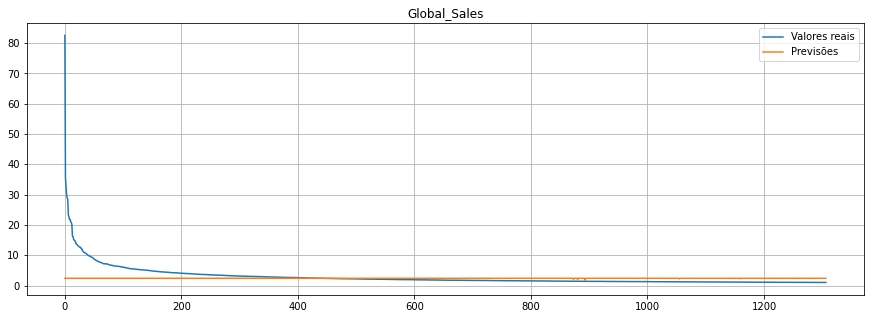

In [37]:
plt.figure(figsize=(15,5))
plt.plot(y, label='Valores reais')
plt.plot(previsoes, label='Previsões')
plt.legend()
plt.grid()
plt.title(df.columns[4]);